# Evaluating the reproducibility of single-cell gene regulatory network inference algorithms

scNET evaluates Gene Regulatory Network inference algorithms based on reproducibility.
This markdown proposes a step by step tutorial for algorithm evaluation.

Datasets used for this tutorial are available in the `scNET_data` directory, or the link https://cloud.biologie.ens.fr/index.php/s/JuJgrIL1jC6yZh4/download, as described in the Github README. Data preprocessing was done as described in the article.

By default, this markdown performs reproducibility analysis for Human Retina data. The same analysis can be repeated on other biological contexts: CRC T-cells and 5 different types of hematopoietic cells by uncommenting its corresponding blocks of code in the `Loading pre-processed input scRNA-seq data` cells.

# Setting the scNET environment

Before loading data, make sure that the scNET environment has been correctly created and activated (see Github README). Additionally, run the following code to ensure an R interface with `jupyter notebook` 


In [1]:
import os

#INSERT HERE THE BASE DIRECTORY OF scNet
scnet_dir = "/home/daniele.capocefalo/homeSing/scHMLNs/scNET" 
os.chdir(scnet_dir)

In [2]:
###interface with R
%load_ext rpy2.ipython

Next, load R functions from the scNET repository 

In [77]:
%%R -i scnet_dir

###load reproducibility functions and libraries
source(file.path(scnet_dir, 'Functions.R'))

# Loading pre-processed input scRNA-seq data 

As described in the methods of the paper, raw count data corresponding to QC passed cells (as per the original articles) was first downloaded and pre-processed. Here, data will be loaded as both Python and R variables, according to each algorithm's specificity (GRNBoost2 and GENIE3 in Python, PPCOR in R).

In this cell, users can comment and uncomment lines depending on the biological context they'd like to analyze. The default is set to Human Retina data.

In [4]:
import glob

#RETINA
files= glob.glob(os.path.join(scnet_dir, 'scNET_data/RETINA/*.csv'))
files
# #CRC T cells
# files= glob.glob('../scNET_data/CRC T-cells/*.csv')

# #Hematopoesis
# files= glob.glob('../scNET_data/HEMATO/*CLP.csv')

# files= glob.glob('../scNET_data/HEMATO/*DC.csv')

# files= glob.glob('../scNET_data/HEMATO/*Ery.csv')

# files= glob.glob('../scNET_data/HEMATO/*HSC.csv')

# files= glob.glob('../scNET_data/HEMATO/*Mono.csv')


['/home/daniele.capocefalo/homeSing/scHMLNs/scNET/scNET_data/RETINA/Lukowski_et_al.csv',
 '/home/daniele.capocefalo/homeSing/scHMLNs/scNET/scNET_data/RETINA/Menon_et_al.csv']

Then, the following cell will load the selected data to Python. Additionally, a list of Transcription Factors (TF) to provide to the algorithms GRNBoost2 and GENIE3 will also be loaded (see GRNBoost2).

In [5]:
#Load data
import pandas as pd
from arboreto.utils import load_tf_names

First_dataset= pd.read_csv(files[0], sep=',', index_col=0)
First_exp= First_dataset.to_numpy()
Second_dataset= pd.read_csv(files[1], sep=',', index_col=0)
Second_exp= Second_dataset.to_numpy()
genes= First_dataset.columns

###Load TF list
tf_names= load_tf_names(os.path.join(scnet_dir, 'scNET_data/TF_names.txt'))

This next cell will load the same data into a R variable. Please make sure that the uncommented lines in this cell corresponds to the biological context selected in the first cell of this section. Again, the default is set to Human Retina data.

In [6]:
%%R -i scnet_dir
#RETINA
setwd(file.path(scnet_dir, 'scNET_data/RETINA/'))
files = list.files(pattern='.csv')


#CRC T-cells
# setwd('../scNET_data/CRC T-cells')
# files= list.files(pattern='.csv')

# #Hematopoesis : CLP
# setwd('../scNET_data/HEMATO')
# files= list.files(pattern='CLP.csv')

# files= list.files(pattern='DC.csv')

# files= list.files(pattern='Ery.csv')

# files= list.files(pattern='HSC.csv')

# files= list.files(pattern='Mono.csv')


###load files 
data= lapply(files, read.csv, row.names=1)

### Create 'Results' directory

In [7]:
resultsdir = os.path.join(scnet_dir, "Results")
try:
    os.mkdir(resultsdir)
except:
    print("WARNING:\n\tdirectory \"{}\" already exists".format(resultsdir))

	directory "/hpcnfs/scratch/temporary/ieo5144/scHMLNs/scNET/Results" already exists


# Running single-cell network inference algorithms

We will now apply GRNBoost2, GENIE3 and PPCOR to the loaded data.
To apply any additional algorithms, refer to Github README

## GRNBoost2

GRNBoost2 (Aibar, S., et al., ) takes as input an expression matrix and produces a list of TF to target interactions. This link list is formatted into 3 columns (column 1: TF, column2: Target, column3: link weight), and represents a directed network. A curated list of human transcription factors(Chawla, K., et al.) is provided as input to steer the inference. The code to apply GRNBoost2 to this data has been configured as described in https://arboreto.readthedocs.io/en/latest/. To speed up computation and produce networks for both datasets at once, a custom Dask client will help paralellize tasks.  

In practice, it is highly recommended to copy the following cell (preceded by the first two cells in the `Loading pre-processed input scRNA-seq data` section) into a seperate script and executing GRNBoost2 independantly, as the network inference is time consuming.

In [9]:
### Applying GRNBoost2###
from arboreto.algo import grnboost2
from distributed import LocalCluster, Client

if __name__ == '__main__':
    # ex_matrix is a DataFrame with gene names as column names
    #build local cluster for parallel computation 
    local_cluster = LocalCluster(n_workers=4,
                                 threads_per_worker=1,
                                 memory_limit=10e9)
    custom_client = Client(local_cluster)
    
    #build networks 
    First_Network = grnboost2(expression_data=First_exp,
                        gene_names= genes,
                        tf_names= tf_names,
                        client_or_address=custom_client,
                        seed=100)
    Second_Network = grnboost2(expression_data=Second_exp,
                        gene_names= genes,
                        tf_names= tf_names,
                        client_or_address=custom_client,
                        seed=100)
    
    #close custom client

    custom_client.close()
    local_cluster.close()
    
    #export networks to results file
    First_Network.to_csv(os.path.join(scnet_dir, 'Results/GRNBoost2_Network1.tsv'), sep='\t', index=False, header=False)
    Second_Network.to_csv(os.path.join(scnet_dir, 'Results/GRNBoost2_Network2.tsv'), sep='\t', index=False, header=False)

## GENIE3

GENIE3 (Aibar, S., et al.) was also provided with a TF list, and produces a link list in the same format as GRNBoost2. Similarly, the code to apply GENIE3 has been configured as described in https://arboreto.readthedocs.io/en/latest/, and the inference is parallelized.  

Again,it is highly recommended to copy the following cell (preceded by the first two cells in the `Loading pre-processed input scRNA-seq data` section) into a seperate script. This is especially pertinent because GENIE3 is  computationally heavier than GRNBoost2

In [ ]:
###Applying GENIE3###
from arboreto.algo import genie3
from distributed import LocalCluster, Client

if __name__ == '__main__':
    # ex_matrix is a DataFrame with gene names as column names
    #build local cluster for parallel computation 
    local_cluster = LocalCluster(n_workers=4,
                                 threads_per_worker=1,
                                 memory_limit=10e9)
    custom_client = Client(local_cluster)
    
    #build networks 
    First_Network = genie3(expression_data=First_exp,
                        gene_names= genes,
                        tf_names= tf_names,
                        client_or_address=custom_client,
                        seed=100)
    Second_Network = genie3(expression_data=Second_exp,
                        gene_names= genes,
                        tf_names= tf_names,
                        client_or_address=custom_client,
                        seed=100)
    
    #close custom client
    custom_client.close()
    local_cluster.close()
    
    #export networks to results file
    First_Network.to_csv(os.path.join(scnet_dir, 'Results/GENIE3_Network1.tsv'), sep='\t', index=False, header=False)
    Second_Network.to_csv(os.path.join(scnet_dir, 'Results/GENIE3_Network2.tsv'), sep='\t', index=False, header=False)

## PPCOR

PPCOR calculates partial Spearman correlation coefficients between ALL possible gene pairs based on gene expression values. This algorithm produces an adjacency matrix, with genes in both columns and rows, and whose values correspond to correlation coefficients. A post-processing step is thus necessary for PPCOR results to 1) select interactions that are the most significant and 2) reformat links into a list that resembles GRNBoost2 and GENIE3 outputs. Note that PPCOR produces an undirected network after post-processing.

Links are selected by setting a threshold on correlation coefficient values. The threshold is determined by calculating a significant correlation coefficent value, given a statistical power P=0.8, a significance level alpha=0.05, and N= the number of cells in the corresponding dataset.

It was noted during the analysis that PPCOR can give non-valid correlation coefficient values (>1 and <-1). The post-processing function checks for the percentage of valid links in ppcor results. If coefficients are not in the expected range, no networks will be produced. For details on the post-processing code, see `Functions.R`

In [11]:
%%R -i scnet_dir
#Applying PPCOR 
library(ppcor)

PPCOR.res.net1= pcor(data[[1]], method= 'spearman')
PPCOR.res.net2= pcor(data[[2]], method= 'spearman')
ppcor.res= list(net1= PPCOR.res.net1, net2=PPCOR.res.net2)

setwd(file.path(scnet_dir, 'Results/'))
saveRDS(ppcor.res, file='PPCOR_raw_results.Rds')

#calculate threhsold according to ncells in each dataset
ncells1= nrow(data[[1]])#cells in rows
thresh1=pwr.r.test(n = ncells1, sig.level = 0.05, power = 0.8, alternative = "two.sided")$r
ncells2= nrow(data[[2]])#cells in rows
thresh2=pwr.r.test(n = ncells2, sig.level = 0.05, power = 0.8, alternative = "two.sided")$r

#Post-process PPCOR results to produce networks
ppcor.net1=ppcor.post(ppcor.res[[1]], coefficient.threshold = thresh1)
ppcor.net2=ppcor.post(ppcor.res[[2]], coefficient.threshold = thresh2)

#Export PPCOR results
if(nrow(ppcor.net1)!= 0 & nrow(ppcor.net2)!=0){
    write.table(ppcor.net1, 'PPCOR_Network1.tsv', quote=F, sep='\t', row.names = F)
    write.table(ppcor.net2, 'PPCOR_Network2.tsv', quote=F, sep='\t', row.names = F)
}else{message('Networks produced by PPCOR can not be analysed for reproducibility')}

# Algorithm reproducibility evaluation

Once all algorithms have been applied on both datasets, their reproducibility can be evaluated. Three metrics are calculated: Intersection index, Weighted Jaccard Similarity (WJS) and RcisTarget score (see Methods for more details, and `Functions.R` for details on the code). 

Before calculating the RcisTarget score, the RcisTarget algorithm(Aibar, S., et al.) must first be applied to all networks. Note that here, RcisTarget has been customized to select only High Confidence links, that are supported by strong motif evidence (see Methods)

**IMPORTANT NOTE**: The Rcis Database for the benchmarking can be downloaded [here](https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg19/refseq_r45/mc9nr/gene_based/hg19-tss-centered-5kb-7species.mc9nr.feather)

In [53]:
%%R -i scnet_dir -o res_dir

#Setting Up directories

res_dir = file.path(scnet_dir, 'Results')

#make a Reproducibility Analysis Directory
output_dir = file.path(res_dir, "Reproducibility_Analysis")
if (!dir.exists(output_dir)){
    print(paste("Creating Reproducibility Analysis directory at:", output_dir, collapse = "\t"))
    dir.create(output_dir, showWarnings = FALSE)
} else {
    print(paste("Reproducibility Analysis directory already exists:", output_dir, "will overwrite", collapse = "\t"))
}

chosenDB = file.path(scnet_dir, "scNET_data", "hg19-tss-centered-5kb-7species.mc9nr.feather")

##### execute Rcistarget#####
Rcis_GRNBoost2 = Custom.Rcis(input.dir=res_dir,
                     pattern='GRNBoost2',
                     chosenDb=chosenDB,
                     output.dir= output_dir,
                     MinGenesetSize=0, 
                     directed=T)
print("Rcis on GRNBoost2 done!")

Rcis_GENIE3 = Custom.Rcis(input.dir=res_dir,
                     pattern='GENIE3',
                     chosenDb=chosenDB,
                     output.dir=output_dir,
                     MinGenesetSize=0, 
                     directed=T)
print("Rcis on GENIE3 done!")

Rcis_PPCOR = Custom.Rcis(input.dir=res_dir,
                     pattern='PPCOR',
                     chosenDb=chosenDB,
                     output.dir=output_dir,
                     MinGenesetSize=0, 
                     directed=F)
print("Rcis on PPCOR done!")

[1] "Reproducibility Analysis directory already exists: /home/daniele.capocefalo/homeSing/scHMLNs/scNET/Results/Reproducibility_Analysis will overwrite"
[1] "Rcis on GRNBoost2 done!"
[1] "Rcis on GENIE3 done!"


R[write to console]: Genes in the gene sets NOT available in the dataset: 
	NELFA: 	1 (0% of 260)
	ZBTB18: 	1 (0% of 270)

R[write to console]: Genes in the gene sets NOT available in the dataset: 
	NELFE: 	1 (0% of 375)
	ZNF322: 	2 (0% of 461)
	HNRNPLL: 	1 (0% of 449)
	CARF: 	1 (0% of 310)
	GPANK1: 	1 (0% of 362)



[1] "Rcis on PPCOR done!"


Once RcisTarget has been applied, we can now calculate reproducibility scores for each algorithm.

In [54]:
%%R -i res_dir
source(file.path(scnet_dir, 'Functions.R'))


###Results
Results= Reproducibility.stats(c('GRNBoost2','GENIE3', 'PPCOR'),
                               Results.dir= res_dir)

R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient



[1] "GRNBoost2 DONE!"


R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient



[1] "GENIE3 DONE!"


R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient



[1] "PPCOR DONE!"


Add Rcis evaluations

In [55]:
%%R -i res_dir

Results[,'RcisTarget_index']= c(Rcis.percent(Rcis_GRNBoost2),
                               Rcis.percent(Rcis_GENIE3),
                               Rcis.percent(Rcis_PPCOR))

Results

  Intersection_index                WJS Algorithm RcisTarget_index
1  0.922713766432937  0.306479690533964 GRNBoost2       0.01781665
2                  1  0.668927588709453    GENIE3       0.01763230
3 0.0664630682359759 0.0251921017337743     PPCOR       0.00000000


The above results can be visualized as barplots, as follows:

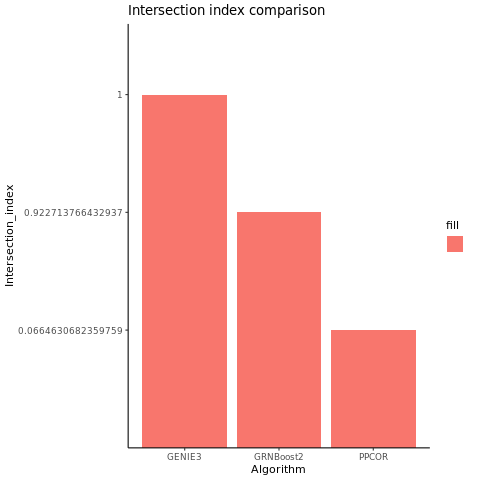

In [60]:
%%R

library(ggplot2)

###Plotting results

ggplot(data=Results, aes(x=Algorithm, y= Intersection_index, fill='')) +
geom_bar(stat="identity")+
ggtitle('Intersection index comparison') + theme_classic()

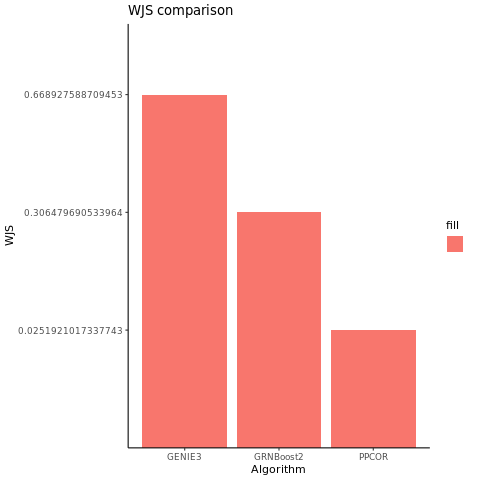

In [58]:
%%R
ggplot(data=Results, aes(x=Algorithm, y= WJS, fill='')) +
geom_bar(stat="identity")+
ggtitle('WJS comparison') + theme_classic()

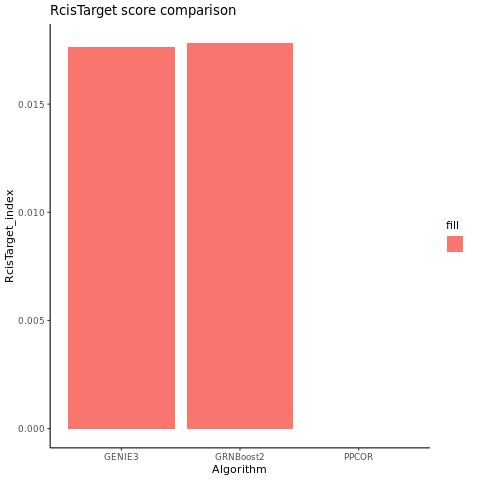

In [59]:
%%R
ggplot(data=Results, aes(x=Algorithm, y= RcisTarget_index, fill='')) +
geom_bar(stat="identity")+
ggtitle('RcisTarget score comparison') + theme_classic()

# Quantile cutting

In this part of the analysis, we threshold network weights according to certain percentiles (40, 80 and 90%). Calculating reproducibility measures for each percentile allows us to compare algorithm stability (see Methods)

In [74]:
%%R -i res_dir

###Quantile Cutting
GRN= lapply(list.files(res_dir, pattern=glob2rx('GRNBoost2*.tsv')), read.table)
GEN= lapply(list.files(res_dir, pattern=glob2rx('GENIE3*.tsv')), read.table)
PPCOR= lapply(list.files(res_dir, pattern=glob2rx('PPCOR*.tsv')), read.table, header=T)

In [79]:
%%R -i scnet_dir

thresh.GRN=quantile.stats(GRN[[1]], GRN[[2]], c(0.4, 0.8, 0.9), Directed=T, label='GRNBoost2')
thresh.GEN=quantile.stats(GEN[[1]], GEN[[2]], c(0.4, 0.8, 0.9), Directed=T, label='GENIE3')
thresh.PPCOR=quantile.stats(PPCOR[[1]], PPCOR[[2]], c(0.4, 0.8, 0.9), Directed=F, label='PPCOR')

R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

R[write to console]: <sparse

In [80]:
%%R 

all.quantiles= rbind(thresh.GRN, thresh.GEN)
all.quantiles= rbind(all.quantiles, thresh.PPCOR)

all.quantiles

  network_size_net1 network_size_net2       intersection                 WJS
1            813762            852661  0.659138667079564   0.294879154934967
2            271254            284221  0.473504538181925   0.269109282669521
3            135627            142111   0.43230330243978   0.258269193036482
4            931650            931650  0.779113400955294   0.523965223927126
5            310550            310550  0.620669779423603   0.390489981132236
6            155275            155275  0.537446465947512   0.327765440316399
7            472106            712337 0.0422426319512991  0.0160593207296045
8            157369            237446 0.0194638079926796 0.00786656990660047
9             78685            118723 0.0148821249285124 0.00643775854269827
  Quantile Algorithm
1      0.4 GRNBoost2
2      0.8 GRNBoost2
3      0.9 GRNBoost2
4      0.4    GENIE3
5      0.8    GENIE3
6      0.9    GENIE3
7      0.4     PPCOR
8      0.8     PPCOR
9      0.9     PPCOR


The above results can be visualized, as follows:

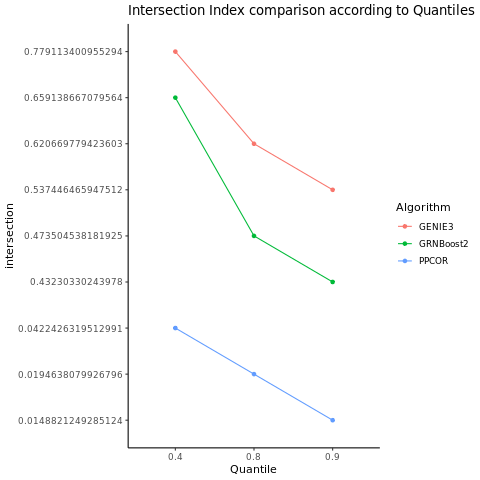

In [83]:
%%R

###Plots
ggplot(data=all.quantiles, aes(x=Quantile, y= intersection, group=Algorithm)) +
  geom_line(aes(color=Algorithm))+
  geom_point(aes(color=Algorithm))+
  ggtitle('Intersection Index comparison according to Quantiles') + theme_classic()

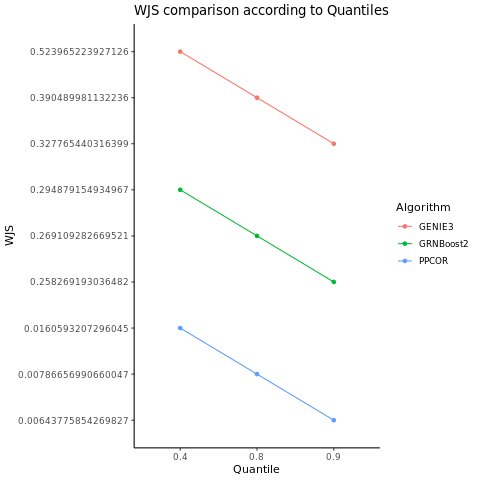

In [82]:
%%R 

ggplot(data=all.quantiles, aes(x=Quantile, y= WJS, group=Algorithm)) +
  geom_line(aes(color=Algorithm))+
  geom_point(aes(color=Algorithm))+
  ggtitle('WJS comparison according to Quantiles') + theme_classic()